# EDA, Cleanup and Pre-processing

Explore and Analyse patterns and trends between nutrition and keto subreddits

- Keto has 2.9M members.
The Ketogenic Diet is a low carbohydrate method of eating. Place to share thoughts, ideas, benefits, and experiences around eating within a Ketogenic lifestyle. Helping people with diabetes, epilepsy, autoimmune disorders, acid reflux, inflammation, hormonal imbalances, and a number of other issues, every day.

- Nutrition has 2.3M members.
A subreddit for the discussion of nutrition science.  Macronutrients, micronutrients, vitamins, diets, and nutrition news are among the many topics discussed. 


In [1]:
#let's import our packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from PIL import Image
from IPython.display import IFrame
import spacy
import scattertext as st
from wordcloud import WordCloud


In [2]:
#show versions of packages
print('pandas: ', pd.__version__)
print('seaborn: ', sns.__version__)
#print('sklearn: ', sklearn.__version__)
print('spacy: ', spacy.__version__)
print('scattertext: ', st.__version__)

pandas:  1.3.4
seaborn:  0.11.1
spacy:  3.2.2
scattertext:  0.1.5


In [3]:
#user defined class
from cv_analyse import cv_analyse

In [4]:
#load the data for nutrition
df_nutrition = pd.read_csv("../datasets/subr_nutrition.csv")
df_keto = pd.read_csv("../datasets/subr_keto.csv")


In [5]:
#check the shape of the datasets
print("Nutrition", df_nutrition.shape)
print("Keto", df_keto.shape)

Nutrition (2000, 11)
Keto (2000, 11)


In [6]:
#check for null values
print(df_keto.isnull().sum().sum(), df_nutrition.isnull().sum().sum())


12 0


In [7]:
#keto seems to be having null values
df_keto.isnull().sum()

created_utc             0
title                   0
selftext               12
is_self                 0
score                   0
upvote_ratio            0
num_comments            0
author                  0
is_original_content     0
media_only              0
subreddit               0
dtype: int64

In [8]:
#fill the selftext with 'NA'
df_keto.fillna('missing', inplace=True)
df_keto.isnull().sum().sum()

0

In [9]:
#create a date from the timestamp
df_keto['date'] = df_keto['created_utc'].apply(lambda x: datetime.fromtimestamp(x).date())
df_nutrition['date'] = df_nutrition['created_utc'].apply(lambda x: datetime.fromtimestamp(x).date())

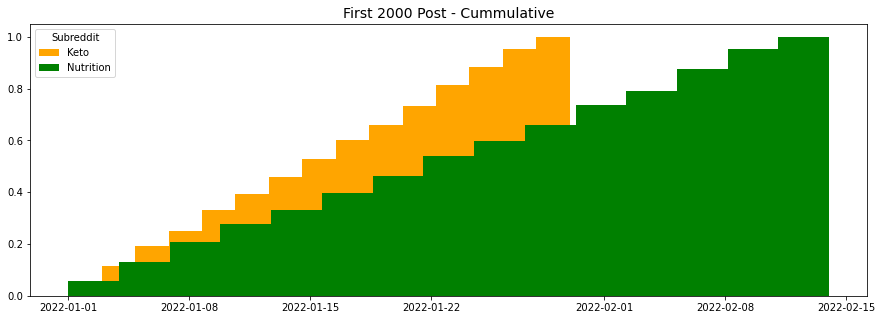

In [10]:
plt.figure(figsize=(15,5))

plt.title("First 2000 Post - Cummulative", fontsize=14)

plt.hist(df_keto['date'], density=True, bins=15,histtype='stepfilled',
                           cumulative=True, label='Empirical', color="orange");

plt.hist(df_nutrition['date'], density=True, bins=15,histtype='stepfilled',
                           cumulative=True, label='Empirical', color="green");

#plt.xticks(df_nutrition['date'], rotation=90)

plt.legend(title='Subreddit', loc='upper left', labels=['Keto', 'Nutrition'], fontsize=10);


***Keto has higher average number of postings than Nutrition, since Keto has 300K more members
Keto reached it's 2K post on 30th Jan while Nutrition needs 14 days more abd reached 2K on 14th Feb***

*Some "selftext" are marked as [removed], check how many are deleted in both subreddits*

In [11]:
df_nutrition["is_removed"] = df_nutrition.apply(lambda x: 1 if x['selftext'] == '[removed]' else 0, axis=1)

In [12]:
df_nutrition["is_removed"].value_counts()

1    1171
0     829
Name: is_removed, dtype: int64

In [13]:
df_keto["is_removed"] = df_keto.apply(lambda x: 1 if x['selftext'] == '[removed]' else 0, axis=1)

In [14]:
df_keto["is_removed"].value_counts()

0    1162
1     838
Name: is_removed, dtype: int64

***42% to 48% of the selftext are [removed]***

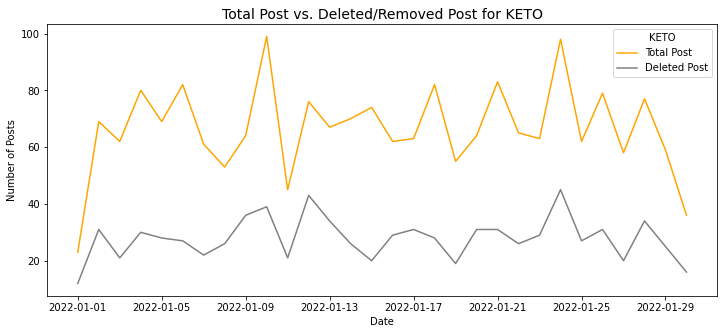

In [15]:
#visualize [removed] post for KETO
plt.figure(figsize=(12,5))

df_keto['date'].value_counts().plot(color="orange")
df_keto[df_keto['selftext'] == '[removed]']['date'].value_counts().plot(color="gray")

plt.xlabel('Date')
plt.ylabel('Number of Posts')



plt.title('Total Post vs. Deleted/Removed Post for KETO', fontsize=14)

plt.legend(title='KETO', loc='best', labels=['Total Post', 'Deleted Post'], fontsize=10);

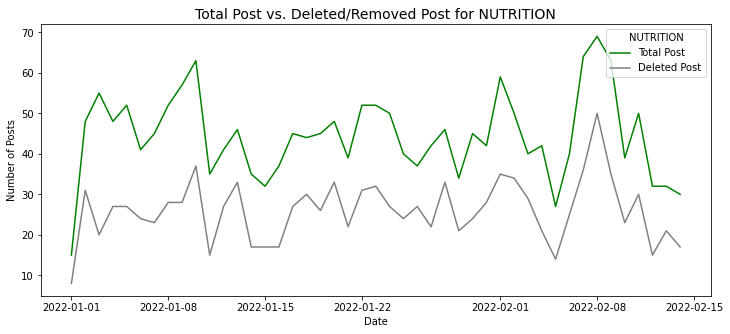

In [16]:
#visualize [removed] post for NUTRITION
plt.figure(figsize=(12,5))

df_nutrition['date'].value_counts().plot(color="green")
df_nutrition[df_nutrition['selftext'] == '[removed]']['date'].value_counts().plot(color="gray")

plt.xlabel('Date')
plt.ylabel('Number of Posts')

plt.title('Total Post vs. Deleted/Removed Post for NUTRITION', fontsize=14)

plt.legend(title='NUTRITION', loc='upper right', labels=['Total Post', 'Deleted Post'], fontsize=10);

***Quick look at the "top" contributing Author, and cleanup if necessary***

In [17]:
df_nutrition['author'].value_counts().sort_values(ascending=False)

Disastrous-Drop-8085    24
DoNotDownVoteMeJerks    13
DScotus                  8
After-Animator9775       8
AutoModerator            7
                        ..
selfdiscoveryb1tches     1
Ajntoin                  1
FoggyTitans              1
SouthernAd5062           1
SnooDoughnuts9618        1
Name: author, Length: 1597, dtype: int64

In [18]:
#lets check the data for Disastrous-Drop-8085    
df_nutrition[df_nutrition['author'] =='Disastrous-Drop-8085'].head()

,created_utc,title,selftext,is_self,score,upvote_ratio,num_comments,author,is_original_content,media_only,subreddit,date,is_removed
1712,1644305616,近年来，我们看到以美国为代表的国家发布了大量APT组织报告，包括针对中国的APT1、APT3...,[removed],True,1,1.0,1,Disastrous-Drop-8085,False,False,nutrition,2022-02-08,1
1713,1644305658,目前，有关APT组织归因的话题已经成为网络空间国家博弈的重要内容，对全球网络空间安全态势造成...,[removed],True,1,1.0,1,Disastrous-Drop-8085,False,False,nutrition,2022-02-08,1
1714,1644305696,美国政府高度重视网络空间威胁归因能力建设。特朗普任内首份《国家安全战略》报告中，强调“投入资...,[removed],True,1,1.0,1,Disastrous-Drop-8085,False,False,nutrition,2022-02-08,1
1715,1644305725,美国网络安全公司是追踪APT组织的主力，如火眼、赛门铁克等众多网络安全企业拥有足以同政府情报...,[removed],True,1,1.0,1,Disastrous-Drop-8085,False,False,nutrition,2022-02-08,1
1716,1644305750,从已披露情况看，美众多网络安全企业围绕有关组织的特征信息等信息，进行了大范围的追踪溯源和关联...,[removed],True,1,1.0,1,Disastrous-Drop-8085,False,False,nutrition,2022-02-08,1


In [19]:
#lets check the data for AutoModerator    
df_nutrition[df_nutrition['author'] =='AutoModerator'].head()

,created_utc,title,selftext,is_self,score,upvote_ratio,num_comments,author,is_original_content,media_only,subreddit,date,is_removed
101,1641186074,/r/Nutrition Weekly Personal Nutrition Discuss...,Welcome to the weekly [r/Nutrition](https://ww...,True,1,1.0,0,AutoModerator,False,False,nutrition,2022-01-03,0
460,1641790876,/r/Nutrition Weekly Personal Nutrition Discuss...,Welcome to the weekly [r/Nutrition](https://ww...,True,1,1.0,0,AutoModerator,False,False,nutrition,2022-01-10,0
733,1642395671,/r/Nutrition Weekly Personal Nutrition Discuss...,Welcome to the weekly [r/Nutrition](https://ww...,True,1,1.0,0,AutoModerator,False,False,nutrition,2022-01-17,0
1062,1643000472,/r/Nutrition Weekly Personal Nutrition Discuss...,Welcome to the weekly [r/Nutrition](https://ww...,True,1,1.0,0,AutoModerator,False,False,nutrition,2022-01-24,0
1345,1643605275,/r/Nutrition Weekly Personal Nutrition Discuss...,Welcome to the weekly [r/Nutrition](https://ww...,True,1,1.0,1,AutoModerator,False,False,nutrition,2022-01-31,0


In [20]:
df_nutrition.shape

(2000, 13)

In [21]:
#remove Disastrous-Drop-8085, as title not in english
#remove AutoModerator
df_nutrition = df_nutrition[(df_nutrition['author'] !='Disastrous-Drop-8085') & (df_nutrition['author'] !='AutoModerator')]

In [22]:
df_nutrition.shape

(1969, 13)

In [23]:
df_keto['author'].value_counts().sort_values(ascending=False)

AutoModerator           28
Basic_Site5449          13
Fearless-Daikon-1533    11
moneyy777                8
Juan9071                 8
                        ..
huniibunnii              1
Blank-VII                1
kikip93                  1
Dangerous_Fix_5502       1
marmalady405             1
Name: author, Length: 1530, dtype: int64

In [24]:
df_keto[df_keto['author']=='Basic_Site5449'].head()

,created_utc,title,selftext,is_self,score,upvote_ratio,num_comments,author,is_original_content,media_only,subreddit,date,is_removed
20,1641048014,How to Care for Your Hair During the Winter Se...,[removed],True,1,1.0,0,Basic_Site5449,False,False,keto,2022-01-01,1
139,1641197517,"Epic EMR - Features, Prices, and Reviews",[removed],True,1,1.0,1,Basic_Site5449,False,False,keto,2022-01-03,1
211,1641287745,7 Heart Numbers You Should Know,[removed],True,1,1.0,0,Basic_Site5449,False,False,keto,2022-01-04,1
281,1641361534,Features of the best forex trading platforms f...,[removed],True,1,1.0,0,Basic_Site5449,False,False,keto,2022-01-05,1
297,1641389684,GeForce RTX 3080 Ti Founders Edition,[removed],True,1,1.0,0,Basic_Site5449,False,False,keto,2022-01-05,1


In [25]:
df_keto[df_keto['author']=='AutoModerator'].head()

,created_utc,title,selftext,is_self,score,upvote_ratio,num_comments,author,is_original_content,media_only,subreddit,date,is_removed
79,1641121214,[2022-01-02] - /r/keto Beginners &amp; Communi...,Hello /r/keto Community!\n\nPlease use this su...,True,1,1.0,0,AutoModerator,False,False,keto,2022-01-02,0
142,1641207612,[2022-01-03] - [My Meal Monday] - What are YOU...,Happy Monday /r/keto!\n\nWe know you've been s...,True,1,1.0,0,AutoModerator,False,False,keto,2022-01-03,0
220,1641294013,[2022-01-04] - /r/keto Beginners &amp; Communi...,Hello /r/keto Community!\n\nPlease use this su...,True,1,1.0,0,AutoModerator,False,False,keto,2022-01-04,0
221,1641294013,[2022-01-04] - [Time Hop Tuesday] - Let's see ...,"It's Tuesday /r/keto!\n\nSo, let's see your B...",True,1,1.0,0,AutoModerator,False,False,keto,2022-01-04,0
289,1641380411,[2022-01-05] - [Weigh-in Wednesday] – Time to ...,"What’s up /r/keto!\n\nIt’s Wednesday, which me...",True,1,1.0,0,AutoModerator,False,False,keto,2022-01-05,0


In [26]:
df_keto.shape

(2000, 13)

In [27]:
#remove author = AutoModerator
df_keto = df_keto[(df_keto['author']!='AutoModerator') & (df_keto['author']!='Basic_Site5449')]

In [28]:
df_keto.shape

(1959, 13)

Duplicates?

In [29]:
#check duplicates in Title for Keto
df_keto.duplicated(subset="title").sum()

45

In [30]:
#check duplicates in Title for Nutrition
df_nutrition.duplicated(subset="title").sum()

49

In [31]:
#drop duplicates in title
df_keto.drop_duplicates(subset="title", inplace=True)
df_nutrition.drop_duplicates(subset="title", inplace=True)

In [32]:
len(df_keto['author'].unique())

1512

In [33]:
len(df_nutrition['author'].unique())

1592

# Word  by Word Analysis via CountVectorizer

In [34]:
def tokenize_lemmetize(text):
    '''
    RegexpTokenizer and WordNetLemmatizer
    '''
    tokenizer = RegexpTokenizer(r'\w+') 
    lemmatizer = WordNetLemmatizer()
    stem = PorterStemmer()
    
    words_token = tokenizer.tokenize(text)
    
    #i think stemming works better than lemmatizing, 
    #some words likes eats, eating, loses, losing are not handled properly by lemmatizer, 
    #so will use stemmer instead
    #words_lem = [lemmatizer.lemmatize(words) for words in words_token]
    
    words_stem = [stem.stem(words) for words in words_token]
    
    return " ".join(words_stem)

In [35]:
#tokenizing and stemming

#Nutrition
df_nutrition["preproc_title"] = df_nutrition["title"].map(tokenize_lemmetize)

#Keto
df_keto["preproc_title"] = df_keto["title"].map(tokenize_lemmetize)

In [36]:
df_nutrition["count_words"] = df_nutrition["preproc_title"].map(lambda x: len(x.split()))
df_keto["count_words"] = df_keto["preproc_title"].map(lambda x: len(x.split()))

In [37]:
df_nutrition[["preproc_title", "count_words"]]

,preproc_title,count_words
0,can blue green alga caus photosensit after cessat,8
1,is eat unsweeten cocoa powder consid a good id...,12
2,broke vegitarian and fodmap pleas help,6
3,how my health relat new year s resolut have went,10
4,way to artifici cancel out a cheat meal,8
...,...,...
1994,what s the deal with alfalfa sprout i can t se...,16
1995,i need to eat healthi for liter the cheapest a...,11
1996,is coconut oil healthi or not healthi there se...,41
1998,becom healthier whi am i more sensit to unheal...,21


In [38]:
df_keto[["preproc_title", "count_words"]]

,preproc_title,count_words
0,are the bhb supplement pill worth get or are t...,11
1,the first thing i wa serv in 2022 wa bone brot...,16
2,pic updat 5 month 60 pound down and final oned...,10
3,daili undesir ketosi,3
4,tomorrow is the big day,5
...,...,...
1995,fat motherfuck,2
1996,brain fog tip,3
1997,evil target,2
1998,so sensit,2


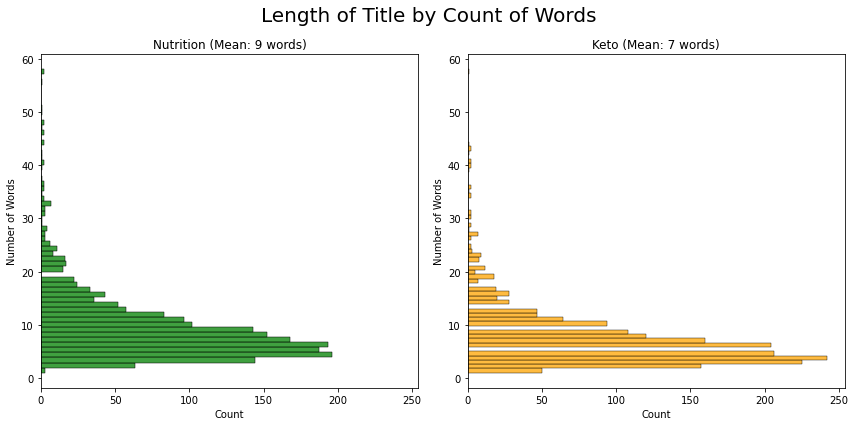

In [39]:
#vizualise

fig, ax = plt.subplots(1, 2, figsize=(12,6), sharex=True)
ax = ax.ravel()
    
# first chart   
c1 = sns.histplot(data=df_nutrition, y='count_words', ax = ax[0],color='green')
mean_1 = df_nutrition['count_words'].mean()

c1.set_title(f'Nutrition (Mean: {round(mean_1)} words)')
c1.set_ylabel('Number of Words')

# second chart
c2 = sns.histplot(data=df_keto, y='count_words', ax = ax[1], color='orange')
mean_2 = df_keto['count_words'].mean()

c2.set_title(f'Keto (Mean: {round(mean_2)} words)')
c2.set_ylabel('Number of Words')
plt.suptitle('Length of Title by Count of Words', fontsize=20)
plt.tight_layout()
    

In [40]:
X=df_nutrition["preproc_title"]
#this is a user-defined class, default value for ngram is a list of 1,2,3, remove stop words
#default max_features=2000
nutri_cv = cv_analyse(X, title="Nutrition")

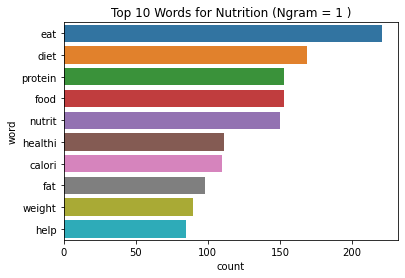

In [41]:
#Nutrition top 15 words
nutri_cv.get_top_N_words(1, 10)

In [42]:
#what is "whi doe"?
nutri_cv.bag_of_words[2][nutri_cv.bag_of_words[2]["whi doe"] > 0]["whi doe"]

61      1
96      1
353     1
703     1
818     1
828     1
966     1
1103    1
1107    1
1281    1
1439    1
1869    1
Name: whi doe, dtype: int64

In [43]:
#check the sample row 61
nutri_cv.X_feature[61]

'whi doe my ribey steak say it ha carb on the nutrit label'

In [44]:
df_nutrition.iloc[61]

#whi doe = Why does (caused by stemming)

created_utc                                                   1641133516
title                  Why does my Ribeye steak say it has carbs on t...
selftext               I bought several natures promise ribeyes at th...
is_self                                                             True
score                                                                  1
upvote_ratio                                                         1.0
num_comments                                                           1
author                                                 johnrangothefirst
is_original_content                                                False
media_only                                                         False
subreddit                                                      nutrition
date                                                          2022-01-02
is_removed                                                             0
preproc_title          whi doe my ribey steak say i

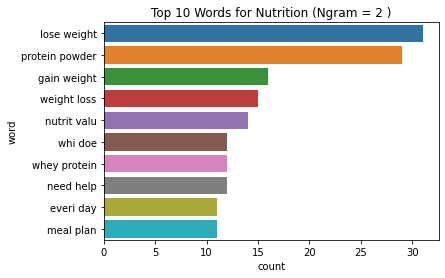

In [45]:
#Nutrition top 15 words
nutri_cv.get_top_N_words(2, 10)

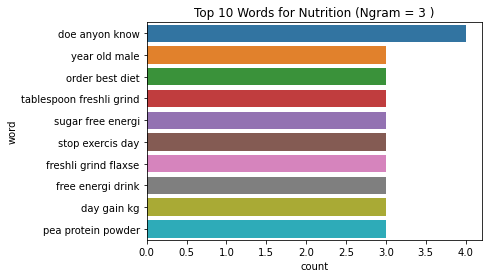

In [46]:
#Nutrition top 2 words
nutri_cv.get_top_N_words(3, 10)

In [47]:
X=df_keto["preproc_title"]
keto_cv = cv_analyse(X,title="Keto")

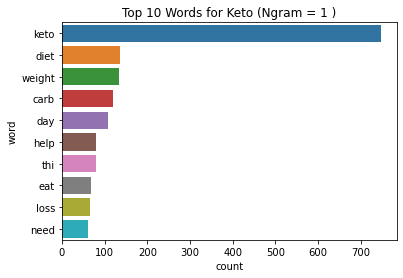

In [48]:
#Nutrition top 15 words (for 1 ngrams)
keto_cv.get_top_N_words(1, 10)

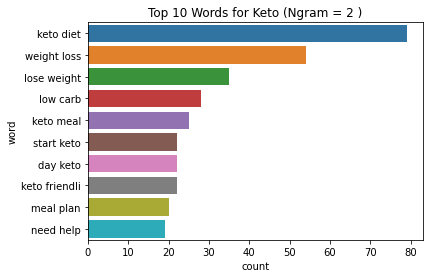

In [49]:
#Nutrition top 15 words (for 2 ngrams)
keto_cv.get_top_N_words(2,10)

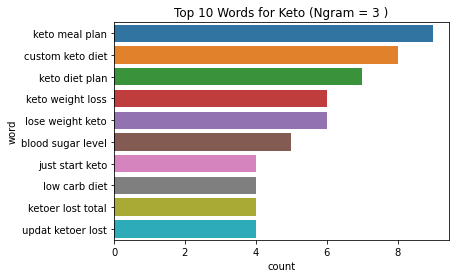

In [50]:
#Keto top 15 words (for 3 ngrams)
keto_cv.get_top_N_words(3,10)

# WordCloud for Presentation

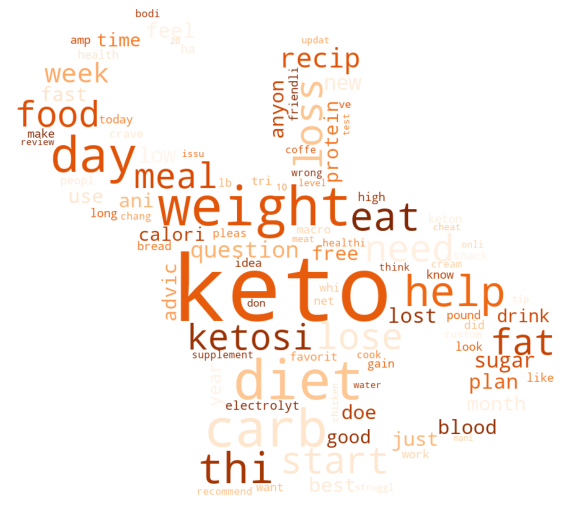

In [51]:
mask = np.array(Image.open("../image/man.jpg"))

word = keto_cv.bag_of_words[1].sum().sort_values(ascending=False).head(100)    
frequencies = word.to_dict()

wordcloud = WordCloud(background_color='white', mask=mask, colormap='Oranges_r').fit_words(frequencies)
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(wordcloud)
_ = ax.axis("off")

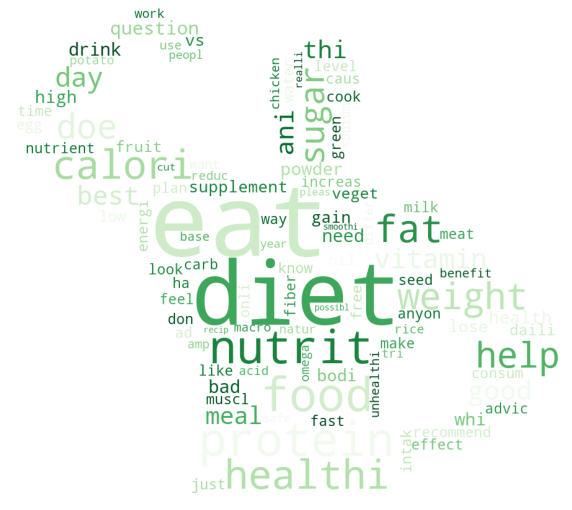

In [52]:
mask = np.array(Image.open("../image/man.jpg"))

word = nutri_cv.bag_of_words[1].sum().sort_values(ascending=False).head(100)    
frequencies = word.to_dict()

wordcloud = WordCloud(background_color='white', mask=mask, colormap='Greens_r').fit_words(frequencies)
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(wordcloud)
_ = ax.axis("off")

## Merge 2 datasets

In [53]:
#combine the datasets
df = pd.concat([df_keto,df_nutrition])

In [54]:
df.shape

(3834, 15)

In [55]:
df["is_nutrition"] = df["subreddit"].map(lambda x: 1 if x == "nutrition" else 0)

In [56]:
df.dtypes

created_utc              int64
title                   object
selftext                object
is_self                   bool
score                    int64
upvote_ratio           float64
num_comments             int64
author                  object
is_original_content       bool
media_only                bool
subreddit               object
date                    object
is_removed               int64
preproc_title           object
count_words              int64
is_nutrition             int64
dtype: object

In [57]:
#saved our dataset for modelling

df.to_csv("../datasets/combined_subr.csv")

# Sentiment Analysis

In [58]:
df_senti = df[['author','title','is_nutrition', 'subreddit']].reset_index(drop=True)

In [59]:
# Initialise VADER
sent = SentimentIntensityAnalyzer()

# Analyzing sentiment with VADER
df_senti['scores'] = df_senti['title'].apply(lambda x: sent.polarity_scores(x))
df_senti['compound']  = df_senti['scores'].apply(lambda x: x['compound'])
df_senti['comp_score'] = df_senti['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')


In [60]:
df_senti[['scores', 'compound','comp_score' ]]

,scores,compound,comp_score
0,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou...",0.2263,pos
1,"{'neg': 0.145, 'neu': 0.855, 'pos': 0.0, 'comp...",-0.2960,neg
2,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
3,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
...,...,...,...
3829,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.2263,pos
3830,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",0.4019,pos
3831,"{'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'comp...",0.7140,pos
3832,"{'neg': 0.177, 'neu': 0.823, 'pos': 0.0, 'comp...",-0.5667,neg


In [61]:
df_senti[df_senti['is_nutrition']==1].describe()

,is_nutrition,compound
count,1920.0,1920.000000
mean,1.0,0.079419
std,0.0,0.324290
min,1.0,-0.822500
25%,1.0,0.000000
50%,1.0,0.000000
75%,1.0,0.340000
max,1.0,0.932500


In [62]:
print('Sentiment for Nutrition:', df_senti[df_senti['is_nutrition']==1]['compound'].mean())
print('Sentiment for Keto:', df_senti[df_senti['is_nutrition']==0]['compound'].mean())

Sentiment for Nutrition: 0.0794193229166667
Sentiment for Keto: 0.04564592476489019


In [63]:
neg_senti_nutrition = df_senti[(df_senti['is_nutrition']==1) 
                       & (df_senti['compound'] < -0.7)]['title'].reset_index()


In [64]:
neg_senti_nutrition['title'][9]

'I screwed up and ate 40 to 60 grams of saturated fat everyday for 2-3 years while bulking. Have I caused ireveisable damage to my body?'

In [65]:
neg_senti_nutrition['title'][10]

"I'm Scared My Diet Is Going To Kill Me Early"

In [66]:
pos_senti_nutrition = df_senti[(df_senti['is_nutrition']==1) 
                       & (df_senti['compound'] > 0.8)]['title'].reset_index()



In [67]:
pos_senti_nutrition['title'][8]

'What are some of the best healthy foods to eat to boost appetite and sustain energy?'

In [68]:
pos_senti_nutrition['title'][0]

'Best liver care for high alcohol consumption'

In [69]:
neg_senti_keto = df_senti[(df_senti['is_nutrition']==0) 
                       & (df_senti['compound'] < -0.8)]['title'].reset_index()

In [70]:
neg_senti_keto['title'][3]

'I want to stick to keto so bad, but I keep finding myself cheating'

In [71]:
pos_senti_keto = df_senti[(df_senti['is_nutrition']==0) 
                       & (df_senti['compound'] > 0.8)]['title'].reset_index()

In [72]:
pos_senti_keto['title'][3]

"The best fish I've ever eaten!! What is your best food?"

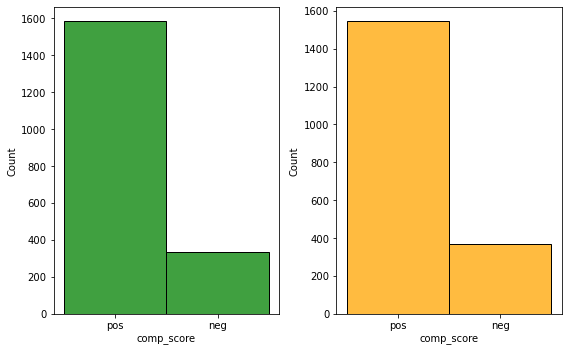

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax = ax.ravel()
sns.histplot(df_senti[df_senti['is_nutrition'] == 1]['comp_score'], color='green', ax = ax[0])
sns.histplot(df_senti[df_senti['is_nutrition'] == 0]['comp_score'], color='orange', ax = ax[1])

plt.tight_layout()

In [74]:
df_senti.groupby(by=['is_nutrition','comp_score']).count()

author  title  subreddit  scores  compound
is_nutrition comp_score                                            
0            neg            369    369        369     369       369
             pos           1545   1545       1545    1545      1545
1            neg            337    337        337     337       337
             pos           1583   1583       1583    1583      1583

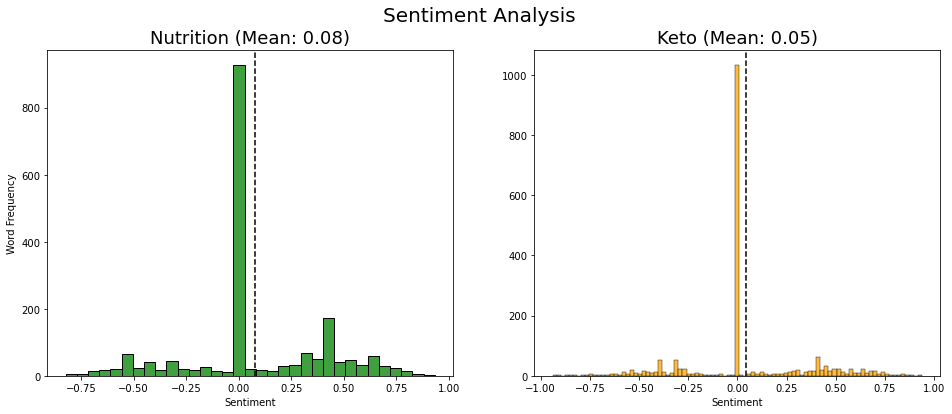

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()
sns.histplot(df_senti[df_senti['is_nutrition'] == 1]['compound'].values, color='green', ax = ax[0])
sns.histplot(df_senti[df_senti['is_nutrition'] == 0]['compound'].values, color='orange', ax = ax[1])
mean_1 = df_senti[df_senti['is_nutrition'] == 1]['compound'].mean()
mean_2 = df_senti[df_senti['is_nutrition'] == 0]['compound'].mean()
ax[0].set_title(f'Nutrition (Mean: {(mean_1):.2f})', fontsize=18)
ax[1].set_title(f'Keto (Mean: {(mean_2):.2f})', fontsize=18)
ax[0].axvline(mean_1, ls='--', color='black')
ax[1].axvline(mean_2, ls='--', color='black')
ax[0].set_xlabel('Sentiment')
ax[0].set_ylabel('Word Frequency')
ax[1].set_xlabel('Sentiment')
ax[1].set_ylabel('')
plt.suptitle('Sentiment Analysis', fontsize=20);

In [76]:
df_senti[df_senti['is_nutrition'] == 1].groupby(by="author")['compound'].mean().sort_values(ascending=False)

author
EvelynIsReal          0.9325
Patknight2018         0.9100
ria_2021              0.8934
DTPW                  0.8625
BedExisting8314       0.8428
                       ...  
duxalex100           -0.7430
GolfBallRocket       -0.7506
WolfgangXIVV         -0.7851
businessmeeting591   -0.7855
JRoss824             -0.8225
Name: compound, Length: 1592, dtype: float64

In [77]:
df_senti[(df_senti['is_nutrition'] == 1)  & (df_senti['author'] == "Patknight2018") ]["title"]

2760    The guys do a free, cool fitness and nutrition...
Name: title, dtype: object

In [78]:
nlp = spacy.load("en_core_web_sm")

In [79]:
# Build corpus for Scattertext sentiment analysis
corpus = st.CorpusFromPandas(df_senti, category_col='comp_score', text_col='title', nlp=nlp).build()

In [80]:
df_senti['comp_score'].value_counts()

pos    3128
neg     706
Name: comp_score, dtype: int64

In [81]:
html = st.produce_scattertext_explorer(corpus, 
                                       category='pos', 
                                       category_name='Positive', 
                                       not_category_name='Negative',
                                       width_in_pixels=1000, 
                                       #metadata=df_senti['subreddit'],
                                       save_svg_button=True)

In [82]:
#save the output to html
html_ = "./output/proj3_nlp.html"
open(html_, 'wb').write(html.encode('utf-8'))

762304

In [83]:
#output of scattertext

IFrame(src="./output/proj3_nlp.html", width=800, height=800)